In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from reference import get_file_names, get_histplot, get_scatter_marker_size
from scipy import stats
import seaborn as sns

In [2]:
df_ref = pd.read_csv('./vidas_data/cross_ref_cols_tabs.csv')
df_referral = pd.read_csv('./vidas_data/survival_time.csv', parse_dates=['EOH', 'SOH'])

In [3]:
plt.rcParams['figure.figsize'] = [20, 12]
matplotlib.rcParams.update({'font.size': 15})
sns.set(font_scale=1.5)

## Use of Megace cor. Appetite ##

In [4]:
# do the merge
df_as = pd.read_csv('./vidas_data/wH_DirectTable_Scala_ESAS.csv', parse_dates=['TimeStamp_Insert'])
df_as = df_as[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'opt_appetito']].dropna().rename(columns={'opt_appetito': 'appetite'})
df_aa = pd.merge(df_referral, df_as, on=['IDEHR', 'EHRType']).dropna().sort_values(by=['IDEHR', 'TimeStamp_Insert'], ascending=[True, True]).reset_index(drop=True)

In [5]:
# clean up the entries in the dframes
df_aa.loc[df_aa['appetite'] == 'N.R.', 'appetite'] = np.nan
df_aa['appetite'] = df_aa.appetite.str.findall('(\d+)#')
df_aa['appetite'] = df_aa['appetite'].apply(lambda x: np.nan if isinstance(x, float) else int(x[0]))
df_aa['hos_days'] = pd.to_timedelta(df_aa['TimeStamp_Insert'] - df_aa['SOH']).dt.days
df_aa.astype({'hos_days': 'float32'}).dtypes
df_aa = df_aa.dropna()
df_aa

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days
0,1489,2015-12-27 03:00:00,AMB,2015-04-21 03:36:25.613,249.0,Palliative (Non-Malignant),586,2015-12-10 12:31:32.910,0.0,233
1,1760,2016-01-12 07:30:00,AMB,2015-04-16 21:20:34.270,270.0,Palliative (Non-Malignant),1,2015-04-21 19:28:37.870,1.0,4
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225
3,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-01 13:46:03.970,2.0,28
4,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-08 14:46:07.657,2.0,35
...,...,...,...,...,...,...,...,...,...,...
4560,29398,2020-07-21 19:30:57,AMB,2020-07-17 09:37:05.790,4.0,Breast,1749,2020-07-21 11:54:38.257,4.0,4
4561,29399,2020-07-23 00:00:21,AMB,2020-07-17 10:08:54.310,5.0,Lung,1630,2020-07-20 12:47:13.370,4.0,3
4562,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 19:00:04.973,1.0,0
4563,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-22 18:09:50.193,1.0,5


In [6]:
# find /i /n "megace" *.csv
# wH_Therapy_JCM_Therapy: Used for analysis
# wH_Therapy_JCM_EHRevent_Therapy: No TimeStamps, very few entries (232 with multiples for same IDEHR)
# wH_DirectTable_Visita_MED_Vidas: Very few entries (32)
# wH_DirectTable_Visita_INF_Vidas: Very few entries (8)
# wH_DirectTable_Terapie_Outpat_Vidas: Used for analysis
# wH_Core_EHRatlerstatehistory: No TimeStamps, very few entries (153 with multiples for same IDEHR)
# wH_Conf_Moduleupdateoperation: Very few entries (14)
# wH_Conf_Spttreetable_Bk: No IDEHR, EHRType columns 

In [7]:
# importing drug dframes
dd1 = pd.read_csv('./vidas_data/wH_Therapy_JCM_Therapy.csv', parse_dates=['DateTherapy', 'TimeStamp_Insert'])
dd2 = pd.read_csv('./vidas_data/wH_DirectTable_TERAPIE_OUTPAT_VIDAS.csv', parse_dates=['TimeStamp_Insert'])

C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# dd1.columns

In [9]:
# clean up data
dd1 = dd1[['IDEHR', 'DateTherapy', 'DrugName', 'Dose', 'ComplementaryCodeDose', 'TimeStamp_Insert']]
dd1 = dd1[dd1['DrugName'].str.contains('MEGACE')]
dd1 = dd1.drop_duplicates().reset_index(drop=True)
# all entries contain the same dosage (160mg)
dd1 = dd1[['IDEHR', 'DrugName', 'TimeStamp_Insert']]
dd1

,IDEHR,DrugName,TimeStamp_Insert
0,1074,MEGACE,2015-02-19 12:16:08.677
1,1074,MEGACE,2015-02-20 07:15:23.203
2,1074,MEGACE,2015-02-21 07:25:37.730
3,1074,MEGACE,2015-02-22 08:03:52.357
4,1074,MEGACE,2015-02-23 08:16:34.217
...,...,...,...
204,5198,MEGACE,2020-06-18 08:04:48.227
205,5198,MEGACE,2020-06-19 09:05:35.427
206,5198,MEGACE,2020-06-20 08:01:43.470
207,5198,MEGACE,2020-06-21 08:00:14.640


In [10]:
dd2 = dd2[['IDEHR', 'opt_farmaco', 'TimeStamp_Insert']]
dd2 = dd2[dd2['opt_farmaco'].str.contains('meges[a-z]+', case=False)]
# all entries contain 160mg of either MEGESTIL or MEGACE
dd2['opt_farmaco'] = 'MEGACE'
# all entries are of AMB
dd2 = dd2.rename(columns={'opt_farmaco': 'DrugName'})
dd2 = dd2.drop_duplicates().reset_index(drop=True)
dd2

,IDEHR,DrugName,TimeStamp_Insert
0,44,MEGACE,2015-01-19 11:02:49.277
1,2231,MEGACE,2015-04-16 22:40:15.103
2,2231,MEGACE,2015-04-17 17:09:48.583
3,1652,MEGACE,2015-04-20 08:49:02.243
4,2248,MEGACE,2015-04-20 17:31:24.037
...,...,...,...
294,28463,MEGACE,2020-05-26 12:24:35.357
295,28463,MEGACE,2020-06-04 09:51:38.593
296,28070,MEGACE,2020-06-23 18:24:10.813
297,26461,MEGACE,2020-07-06 11:13:17.573


In [11]:
# concat both dframes
d_drug = pd.concat([dd1, dd2], ignore_index=True)
d_drug = d_drug.rename(columns={'TimeStamp_Insert': 'DrugTime'})
d_drug.drop_duplicates()

,IDEHR,DrugName,DrugTime
0,1074,MEGACE,2015-02-19 12:16:08.677
1,1074,MEGACE,2015-02-20 07:15:23.203
2,1074,MEGACE,2015-02-21 07:25:37.730
3,1074,MEGACE,2015-02-22 08:03:52.357
4,1074,MEGACE,2015-02-23 08:16:34.217
...,...,...,...
503,28463,MEGACE,2020-05-26 12:24:35.357
504,28463,MEGACE,2020-06-04 09:51:38.593
505,28070,MEGACE,2020-06-23 18:24:10.813
506,26461,MEGACE,2020-07-06 11:13:17.573


In [12]:
print('No. of unique IDEHRs: ', len(d_drug.IDEHR.unique()))

No. of unique IDEHRs:  178


In [13]:
# merge drug df with appetite df
df_cor = pd.merge(df_aa, d_drug, on=['IDEHR'], how='left')
df_cor

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
0,1489,2015-12-27 03:00:00,AMB,2015-04-21 03:36:25.613,249.0,Palliative (Non-Malignant),586,2015-12-10 12:31:32.910,0.0,233,NaN,NaT
1,1760,2016-01-12 07:30:00,AMB,2015-04-16 21:20:34.270,270.0,Palliative (Non-Malignant),1,2015-04-21 19:28:37.870,1.0,4,NaN,NaT
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,MEGACE,2015-12-16 18:59:26.997
3,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-01 13:46:03.970,2.0,28,NaN,NaT
4,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-08 14:46:07.657,2.0,35,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
4508,29398,2020-07-21 19:30:57,AMB,2020-07-17 09:37:05.790,4.0,Breast,1749,2020-07-21 11:54:38.257,4.0,4,NaN,NaT
4509,29399,2020-07-23 00:00:21,AMB,2020-07-17 10:08:54.310,5.0,Lung,1630,2020-07-20 12:47:13.370,4.0,3,NaN,NaT
4510,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 19:00:04.973,1.0,0,NaN,NaT
4511,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-22 18:09:50.193,1.0,5,NaN,NaT


In [14]:
# separate into two dfs: one with the usage of megace and the other without
df_c1 = df_cor[df_cor['DrugName'] == 'MEGACE']
df_c2 = df_cor[df_cor['DrugName'] != 'MEGACE']

In [15]:
df_c1

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,MEGACE,2015-12-16 18:59:26.997
114,3134,2018-11-05 18:50:00,EHR,2018-08-14 17:10:38.117,83.0,Lung,1629,2018-08-16 13:45:00.630,0.0,1,MEGACE,2015-12-04 09:13:38.473
455,3714,2016-01-30 09:58:00,AMB,2015-10-21 12:31:41.467,100.0,Lung,5193,2015-11-30 12:40:47.543,5.0,40,MEGACE,2015-12-03 10:33:58.310
456,3714,2019-08-20 15:25:00,EHR,2019-08-12 10:20:30.957,8.0,Breast,1749,2019-08-17 11:17:03.113,4.0,5,MEGACE,2015-12-03 10:33:58.310
467,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-08-29 11:51:21.883
...,...,...,...,...,...,...,...,...,...,...,...,...
4364,28070,2020-07-02 08:00:40,AMB,2020-04-30 18:30:15.927,62.0,Breast,1748,2020-06-24 13:37:39.180,0.0,54,MEGACE,2020-06-23 18:24:10.813
4389,28243,2020-05-24 06:55:30,AMB,2020-05-11 14:05:33.613,12.0,Brain-Snc,1919,2020-05-14 23:57:58.537,8.0,3,MEGACE,2020-05-12 11:33:25.157
4390,28243,2020-05-24 06:55:30,AMB,2020-05-11 14:05:33.613,12.0,Brain-Snc,1919,2020-05-14 23:57:58.537,8.0,3,MEGACE,2020-05-20 11:23:38.420
4421,28463,2020-06-06 04:00:51,AMB,2020-05-20 17:42:30.647,16.0,Lung,1629,2020-05-21 11:27:02.720,5.0,0,MEGACE,2020-05-26 12:24:35.357


In [16]:
df_c1['drug_days'] = pd.to_timedelta(df_c1['DrugTime'] - df_c1['TimeStamp_Insert']).dt.days
df_c1.astype({'drug_days': 'float32'}).dtypes

<ipython-input-16-5e9fd5c236f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c1['drug_days'] = pd.to_timedelta(df_c1['DrugTime'] - df_c1['TimeStamp_Insert']).dt.days


IDEHR                          int64
EOH                   datetime64[ns]
EHRType                       object
SOH                   datetime64[ns]
survival_time_days           float64
Diagnosis                     object
Diag_Ref                       int64
TimeStamp_Insert      datetime64[ns]
appetite                     float64
hos_days                       int64
DrugName                      object
DrugTime              datetime64[ns]
drug_days                    float32
dtype: object

In [17]:
df_c1

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime,drug_days
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,MEGACE,2015-12-16 18:59:26.997,18
114,3134,2018-11-05 18:50:00,EHR,2018-08-14 17:10:38.117,83.0,Lung,1629,2018-08-16 13:45:00.630,0.0,1,MEGACE,2015-12-04 09:13:38.473,-987
455,3714,2016-01-30 09:58:00,AMB,2015-10-21 12:31:41.467,100.0,Lung,5193,2015-11-30 12:40:47.543,5.0,40,MEGACE,2015-12-03 10:33:58.310,2
456,3714,2019-08-20 15:25:00,EHR,2019-08-12 10:20:30.957,8.0,Breast,1749,2019-08-17 11:17:03.113,4.0,5,MEGACE,2015-12-03 10:33:58.310,-1354
467,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-08-29 11:51:21.883,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364,28070,2020-07-02 08:00:40,AMB,2020-04-30 18:30:15.927,62.0,Breast,1748,2020-06-24 13:37:39.180,0.0,54,MEGACE,2020-06-23 18:24:10.813,-1
4389,28243,2020-05-24 06:55:30,AMB,2020-05-11 14:05:33.613,12.0,Brain-Snc,1919,2020-05-14 23:57:58.537,8.0,3,MEGACE,2020-05-12 11:33:25.157,-3
4390,28243,2020-05-24 06:55:30,AMB,2020-05-11 14:05:33.613,12.0,Brain-Snc,1919,2020-05-14 23:57:58.537,8.0,3,MEGACE,2020-05-20 11:23:38.420,5
4421,28463,2020-06-06 04:00:51,AMB,2020-05-20 17:42:30.647,16.0,Lung,1629,2020-05-21 11:27:02.720,5.0,0,MEGACE,2020-05-26 12:24:35.357,5


In [18]:
df_c1 = df_c1[df_c1['drug_days'] >= 0]
df_c1 = df_c1[df_c1['drug_days'] <= 7]

In [19]:
df_c1

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime,drug_days
455,3714,2016-01-30 09:58:00,AMB,2015-10-21 12:31:41.467,100.0,Lung,5193,2015-11-30 12:40:47.543,5.0,40,MEGACE,2015-12-03 10:33:58.310,2
468,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-08-30 08:13:11.973,0
469,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-08-31 09:03:47.450,1
470,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-01 08:45:53.153,2
471,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-02 08:58:38.123,3
472,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-03 08:22:00.627,4
473,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-04 08:18:52.037,5
474,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-05 09:25:54.280,6
475,3736,2019-09-10 11:35:00,EHR,2019-08-27 09:47:14.353,14.0,Breast,1748,2019-08-29 13:01:48.523,0.0,2,MEGACE,2019-09-06 08:58:01.337,7
546,3982,2015-12-09 10:00:00,AMB,2015-11-11 18:23:26.250,27.0,Breast,1749,2015-11-12 17:41:00.907,0.0,0,MEGACE,2015-11-12 17:55:49.147,0


In [20]:
df_c2

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
0,1489,2015-12-27 03:00:00,AMB,2015-04-21 03:36:25.613,249.0,Palliative (Non-Malignant),586,2015-12-10 12:31:32.910,0.0,233,NaN,NaT
1,1760,2016-01-12 07:30:00,AMB,2015-04-16 21:20:34.270,270.0,Palliative (Non-Malignant),1,2015-04-21 19:28:37.870,1.0,4,NaN,NaT
3,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-01 13:46:03.970,2.0,28,NaN,NaT
4,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-08 14:46:07.657,2.0,35,NaN,NaT
5,2853,2016-01-21 18:30:00,AMB,2015-09-03 12:10:44.877,140.0,Pancreas,1579,2015-10-02 15:18:47.473,5.0,29,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
4508,29398,2020-07-21 19:30:57,AMB,2020-07-17 09:37:05.790,4.0,Breast,1749,2020-07-21 11:54:38.257,4.0,4,NaN,NaT
4509,29399,2020-07-23 00:00:21,AMB,2020-07-17 10:08:54.310,5.0,Lung,1630,2020-07-20 12:47:13.370,4.0,3,NaN,NaT
4510,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 19:00:04.973,1.0,0,NaN,NaT
4511,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-22 18:09:50.193,1.0,5,NaN,NaT


In [21]:
# get the list of patients under megace and ones without
id_meg = df_c1.IDEHR.unique()
id_nmeg = df_c2.IDEHR.unique()
print(list(set(id_meg) & set(id_nmeg)))

[]


In [22]:
df_c3 = df_c1[['IDEHR', 'hos_days', 'appetite']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()
df_c4 = df_c2[['IDEHR', 'hos_days', 'appetite']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()

In [23]:
m_num = len(df_c1.IDEHR.unique())
mn_num = len(df_c2.IDEHR.unique())

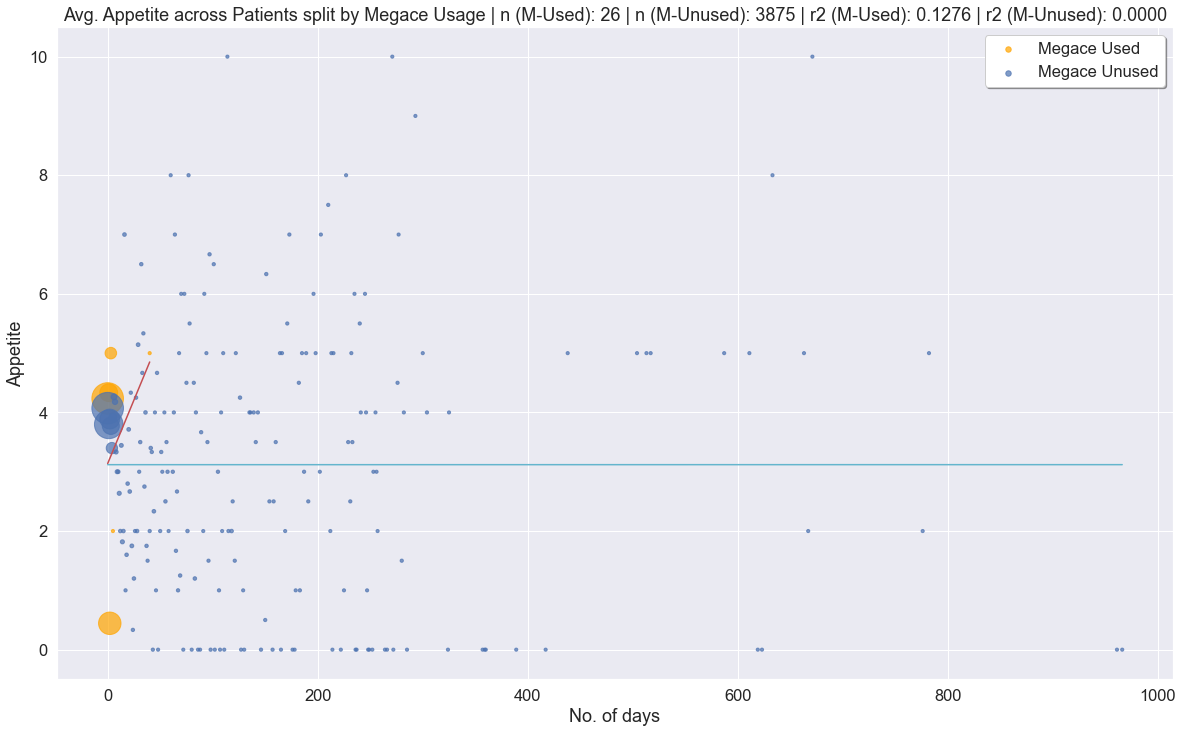

In [24]:
# get the appetite regplots split by megace usage
fig, ax = plt.subplots()
x_ehr = df_c3['hos_days']
y_ehr = df_c3['appetite']['mean']
slope, intercept, r_value_ehr, p_value, std_err = stats.linregress(x_ehr,y_ehr)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_c3['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, slope*x_ehr + intercept, color='r')
x_amb = df_c4['hos_days']
y_amb = df_c4['appetite']['mean']
slope, intercept, r_value_amb, p_value, std_err = stats.linregress(x_amb,y_amb)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_c4['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, slope*x_amb + intercept, color='c')
lgnd = ax.legend((l1, l2), ('Megace Used', 'Megace Unused'), loc='best', shadow=True, facecolor='w')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax.set_xlabel('No. of days')
ax.set_ylabel('Appetite')
ax.set_title('Avg. Appetite across Patients split by Megace Usage | n (M-Used): ' + str(m_num) + ' | n (M-Unused): ' + str(mn_num) + ' | r2 (M-Used): ' + "{:.4f}".format(r_value_ehr ** 2) + " | r2 (M-Unused): " + "{:.4f}".format(r_value_amb ** 2))
plt.savefig('./graphs/correlations/avg_megace.png', bbox_inches='tight')
plt.show()

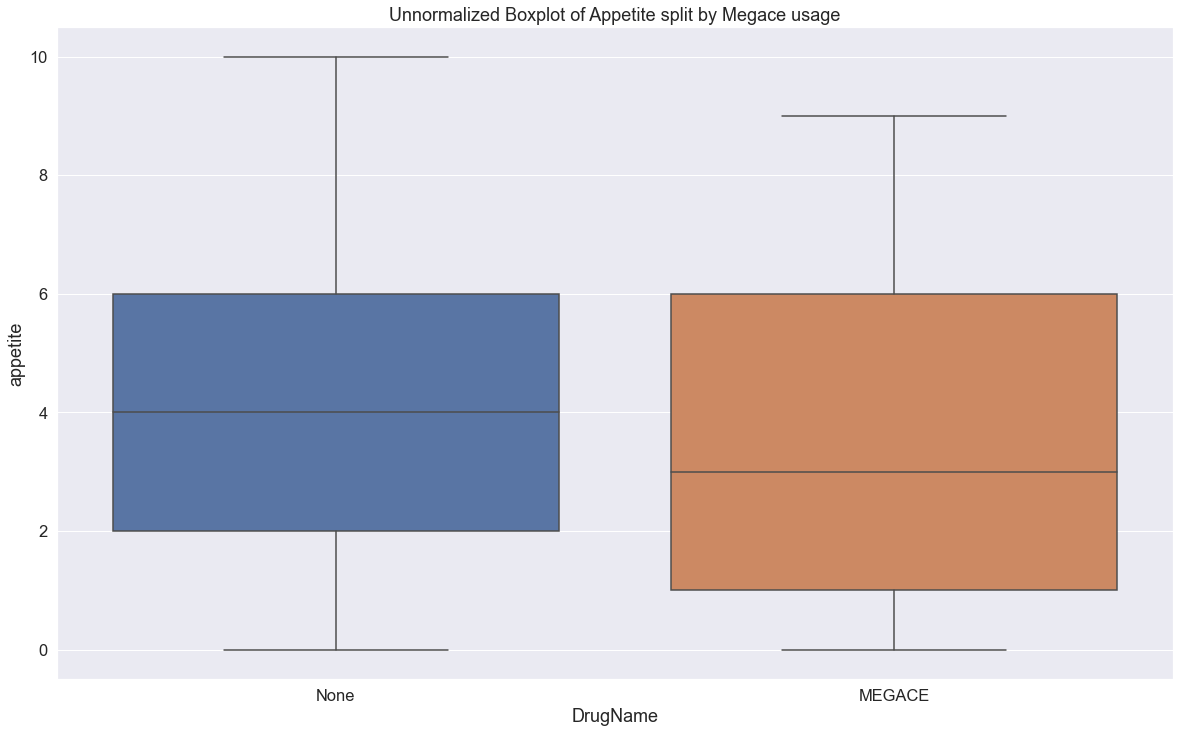

In [25]:
# boxplot for appetite distribution split by megace usage
df_cor.loc[df_cor['DrugName'] != 'MEGACE', 'DrugName'] = 'None'
fig, ax = plt.subplots()
sns.boxplot(x='DrugName', y='appetite', data=df_cor, ax=ax)
ax.set_title('Unnormalized Boxplot of Appetite split by Megace usage')
plt.savefig('./graphs/correlations/app_megace_split_unnorm.png', bbox_inches='tight')
plt.show()

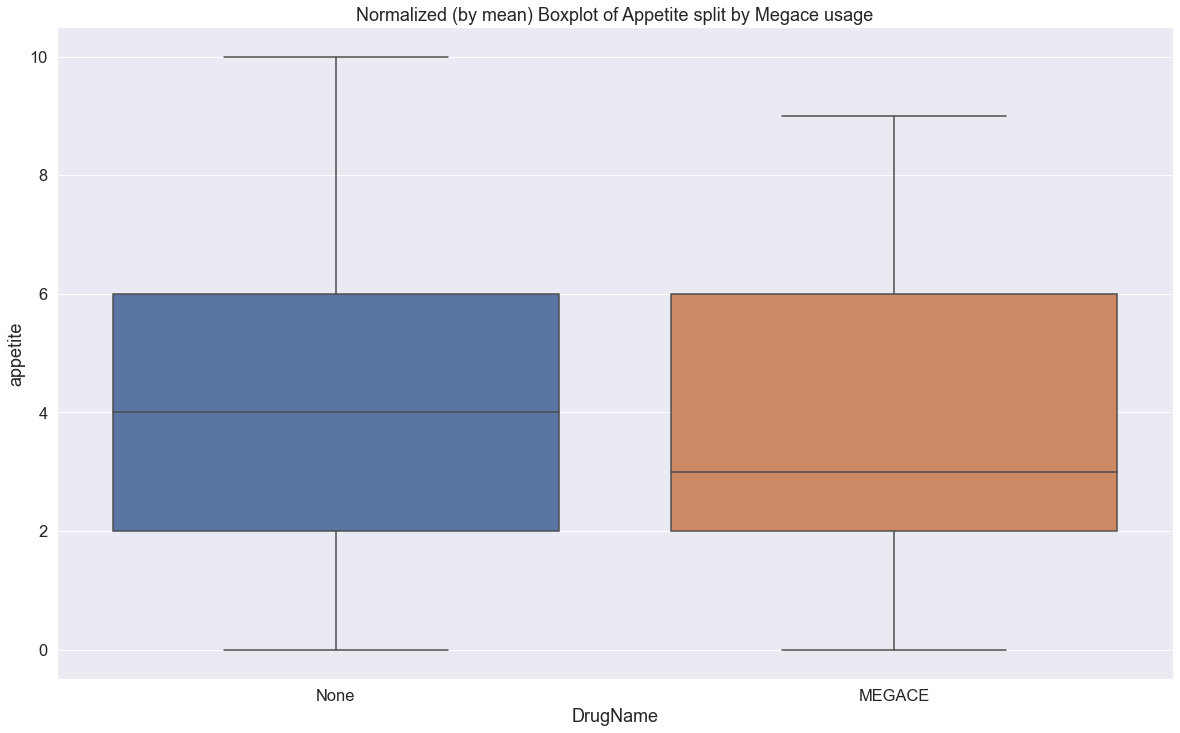

In [26]:
dft = df_cor[['IDEHR', 'appetite', 'DrugName']].groupby(by=['IDEHR', 'DrugName']).mean().reset_index()
fig, ax = plt.subplots()
sns.boxplot(x='DrugName', y='appetite', data=dft, ax=ax)
ax.set_title('Normalized (by mean) Boxplot of Appetite split by Megace usage')
plt.savefig('./graphs/correlations/app_megace_split_mean.png', bbox_inches='tight')
plt.show()

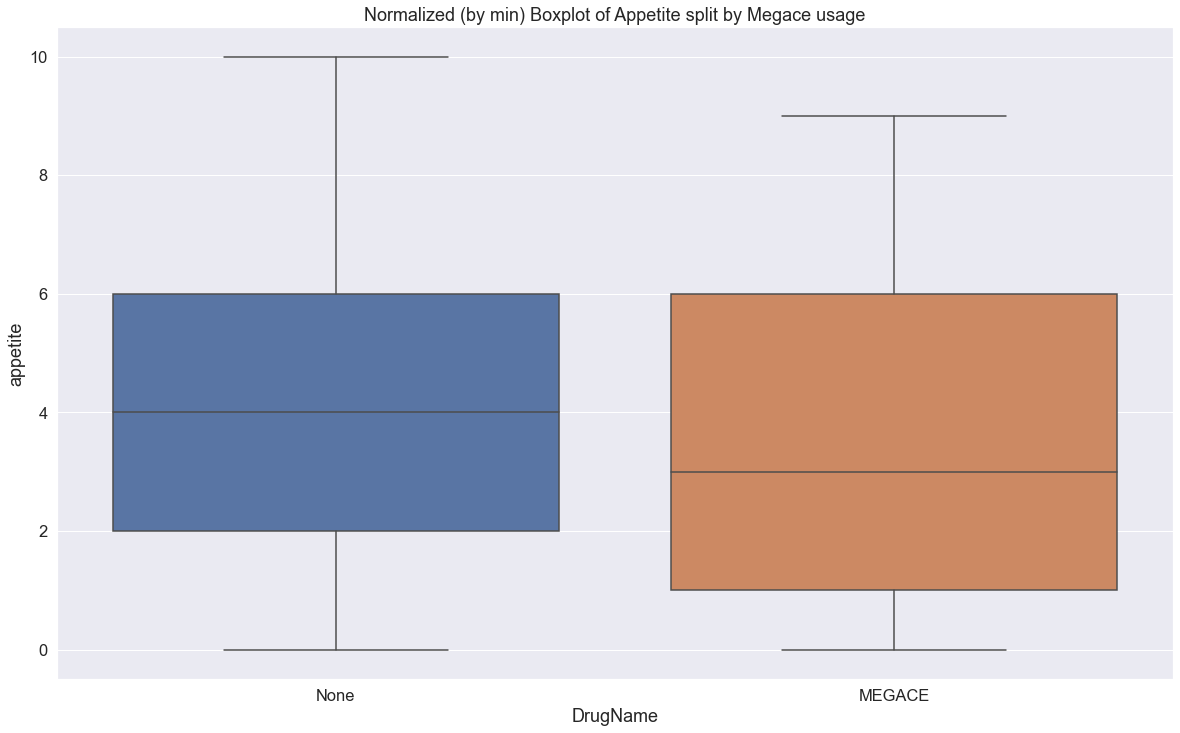

In [27]:
dft = df_cor[['IDEHR', 'appetite', 'DrugName']].groupby(by=['IDEHR', 'DrugName']).min().reset_index()
fig, ax = plt.subplots()
sns.boxplot(x='DrugName', y='appetite', data=dft, ax=ax)
ax.set_title('Normalized (by min) Boxplot of Appetite split by Megace usage')
plt.savefig('./graphs/correlations/app_megace_split_min.png', bbox_inches='tight')
plt.show()

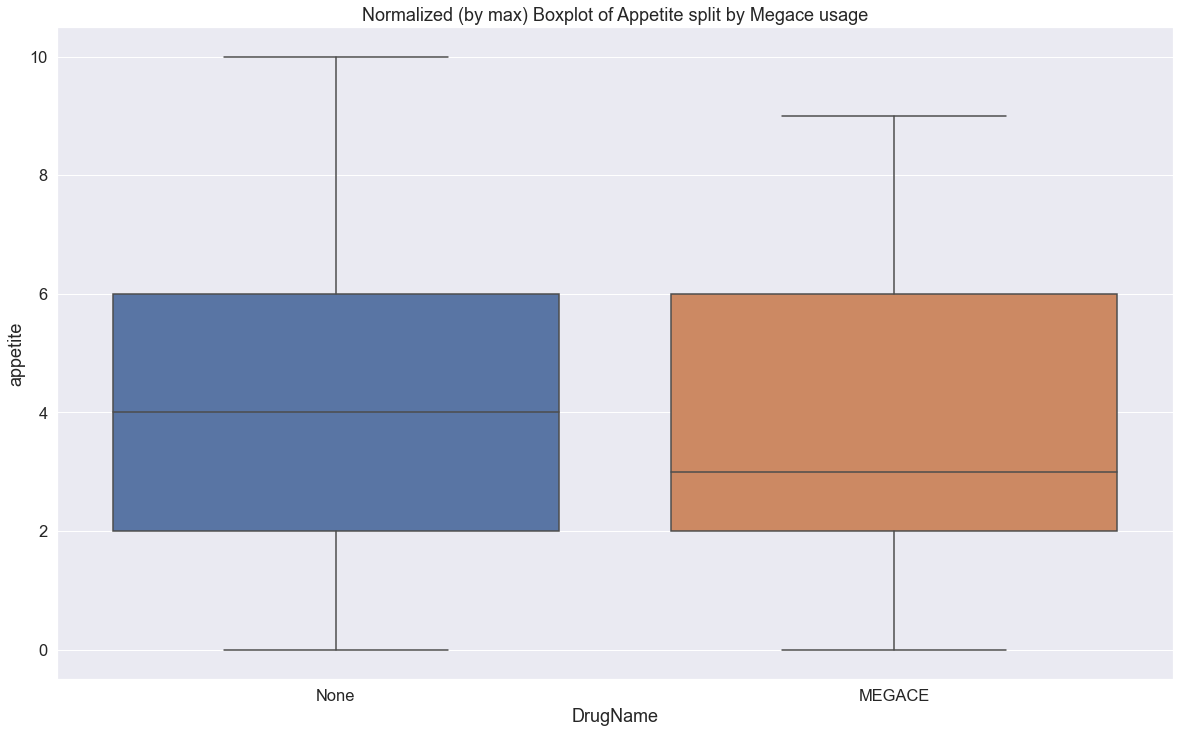

In [28]:
dft = df_cor[['IDEHR', 'appetite', 'DrugName']].groupby(by=['IDEHR', 'DrugName']).max().reset_index()
fig, ax = plt.subplots()
sns.boxplot(x='DrugName', y='appetite', data=dft, ax=ax)
ax.set_title('Normalized (by max) Boxplot of Appetite split by Megace usage')
plt.savefig('./graphs/correlations/app_megace_split_max.png', bbox_inches='tight')
plt.show()

## Appetite Stimulant Trajectories ##

In [29]:
# importing drug dframes
dd1 = pd.read_csv('./vidas_data/wH_Therapy_JCM_Therapy.csv', parse_dates=['DateTherapy', 'TimeStamp_Insert'])
dd2 = pd.read_csv('./vidas_data/wH_DirectTable_TERAPIE_OUTPAT_VIDAS.csv', parse_dates=['TimeStamp_Insert'])

C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [30]:
# clean up data
dd1 = dd1[['IDEHR', 'DateTherapy', 'DrugName', 'Dose', 'ComplementaryCodeDose', 'TimeStamp_Insert']]
dd1 = dd1[dd1['DrugName'].str.contains('OMEPRAZOLO|LANSOPRAZOLO')]
dd1 = dd1.drop_duplicates().reset_index(drop=True)
dd1 = dd1[['IDEHR', 'DrugName', 'TimeStamp_Insert']]
dd1

,IDEHR,DrugName,TimeStamp_Insert
0,1020,OMEPRAZOLO TEVA,2015-01-10 13:27:23.490
1,3,LANSOPRAZOLO MG,2015-01-10 13:57:34.633
2,8,LANSOPRAZOLO MG,2015-01-10 15:49:53.713
3,3,LANSOPRAZOLO MG,2015-01-11 08:52:37.690
4,8,LANSOPRAZOLO MG,2015-01-11 08:54:12.127
...,...,...,...
6136,5230,OMEPRAZOLO EG,2020-07-01 08:30:57.707
6137,5230,OMEPRAZOLO EG,2020-07-02 08:16:25.363
6138,5230,OMEPRAZOLO EG,2020-07-03 08:41:19.687
6139,5280,OMEPRAZOLO EG,2020-07-22 08:32:08.367


In [31]:
dd1.DrugName.unique()

array(['OMEPRAZOLO TEVA', 'LANSOPRAZOLO MG', 'OMEPRAZOLO DOC',
       'OMEPRAZOLO EG', 'OMEPRAZOLO ACT.PTC', 'ESOMEPRAZOLO TEVA',
       'OMEPRAZOLO RANB', 'ESOMEPRAZOLO SAND', 'LANSOPRAZOLO SAN',
       'ESOMEPRAZOLO EG', 'OMEPRAZOLO SAND', 'OMEPRAZOLO SA',
       'OMEPRAZOLO EU', 'LANSOPRAZOLO EG', 'LANSOPRAZOLO DOC G',
       'ESOMEPRAZOLO EU', 'ESOMEPRAZOLO MG', 'OMEPRAZOLO ANG',
       'OMEPRAZOLO HEXAL AG', 'OMEPRAZOLO PEN', 'OMEPRAZOLO RPN'],
      dtype=object)

In [32]:
dd2 = dd2[['IDEHR', 'opt_farmaco', 'TimeStamp_Insert']]
dd2 = dd2[dd2['opt_farmaco'].str.contains('omepra[a-z]+', case=False)]
dd2['opt_farmaco'] = 'OMEPRAZOLE'
# all entries are of AMB
dd2 = dd2.rename(columns={'opt_farmaco': 'DrugName'})
dd2 = dd2.drop_duplicates().reset_index(drop=True)
dd2

,IDEHR,DrugName,TimeStamp_Insert
0,119,OMEPRAZOLE,2015-01-20 16:38:56.957
1,1236,OMEPRAZOLE,2015-01-21 08:45:33.673
2,83,OMEPRAZOLE,2015-01-21 12:27:48.417
3,116,OMEPRAZOLE,2015-01-22 08:27:07.113
4,68,OMEPRAZOLE,2015-01-22 10:13:10.287
...,...,...,...
6513,25822,OMEPRAZOLE,2020-07-23 12:14:13.007
6514,28512,OMEPRAZOLE,2020-07-23 13:23:03.603
6515,27910,OMEPRAZOLE,2020-07-23 13:58:03.510
6516,25550,OMEPRAZOLE,2020-07-23 17:01:25.897


In [33]:
# concat both dframes
d_drug = pd.concat([dd1, dd2], ignore_index=True)
d_drug = d_drug.rename(columns={'TimeStamp_Insert': 'DrugTime'})
d_drug.drop_duplicates()

,IDEHR,DrugName,DrugTime
0,1020,OMEPRAZOLO TEVA,2015-01-10 13:27:23.490
1,3,LANSOPRAZOLO MG,2015-01-10 13:57:34.633
2,8,LANSOPRAZOLO MG,2015-01-10 15:49:53.713
3,3,LANSOPRAZOLO MG,2015-01-11 08:52:37.690
4,8,LANSOPRAZOLO MG,2015-01-11 08:54:12.127
...,...,...,...
12654,25822,OMEPRAZOLE,2020-07-23 12:14:13.007
12655,28512,OMEPRAZOLE,2020-07-23 13:23:03.603
12656,27910,OMEPRAZOLE,2020-07-23 13:58:03.510
12657,25550,OMEPRAZOLE,2020-07-23 17:01:25.897


In [34]:
d_drug['DrugName'] = 'OMEPRAZOLE'

In [35]:
print('No. of unique IDEHRs: ', len(d_drug.IDEHR.unique()))

No. of unique IDEHRs:  2978


In [36]:
# merge drug df with appetite df
df_cor = pd.merge(df_aa, d_drug, on=['IDEHR'], how='left')
df_cor

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
0,1489,2015-12-27 03:00:00,AMB,2015-04-21 03:36:25.613,249.0,Palliative (Non-Malignant),586,2015-12-10 12:31:32.910,0.0,233,NaN,NaT
1,1760,2016-01-12 07:30:00,AMB,2015-04-16 21:20:34.270,270.0,Palliative (Non-Malignant),1,2015-04-21 19:28:37.870,1.0,4,NaN,NaT
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2015-09-30 17:01:36.237
3,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2016-03-15 15:13:08.197
4,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2016-07-12 14:36:03.090
...,...,...,...,...,...,...,...,...,...,...,...,...
8210,29398,2020-07-21 19:30:57,AMB,2020-07-17 09:37:05.790,4.0,Breast,1749,2020-07-21 11:54:38.257,4.0,4,OMEPRAZOLE,2020-07-21 11:54:03.967
8211,29399,2020-07-23 00:00:21,AMB,2020-07-17 10:08:54.310,5.0,Lung,1630,2020-07-20 12:47:13.370,4.0,3,NaN,NaT
8212,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 19:00:04.973,1.0,0,NaN,NaT
8213,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-22 18:09:50.193,1.0,5,NaN,NaT


In [37]:
# separate into two dfs: one with the usage of omeprazole and the other without
df_c1 = df_cor[df_cor['DrugName'] == 'OMEPRAZOLE']
df_c2 = df_cor[df_cor['DrugName'] != 'OMEPRAZOLE']

In [38]:
df_c1

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
2,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2015-09-30 17:01:36.237
3,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2016-03-15 15:13:08.197
4,1994,2016-07-09 20:00:00,AMB,2015-04-15 22:42:22.550,450.0,Cervical-Ovarian,1830,2015-11-27 20:13:44.800,1.0,225,OMEPRAZOLE,2016-07-12 14:36:03.090
5,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-01 13:46:03.970,2.0,28,OMEPRAZOLE,2015-10-01 13:45:58.670
6,2833,2015-12-09 13:30:00,AMB,2015-09-02 17:04:00.623,97.0,GI Tract,1533,2015-10-01 13:46:03.970,2.0,28,OMEPRAZOLE,2015-11-26 13:50:32.527
...,...,...,...,...,...,...,...,...,...,...,...,...
8199,29184,2020-07-10 00:00:26,AMB,2020-07-01 15:02:34.620,8.0,Genitourinary,1890,2020-07-02 16:04:57.253,0.0,1,OMEPRAZOLE,2020-07-02 07:28:34.760
8200,29184,2020-07-10 00:00:26,AMB,2020-07-01 15:02:34.620,8.0,Genitourinary,1890,2020-07-02 16:04:57.253,0.0,1,OMEPRAZOLE,2020-07-07 17:02:19.107
8206,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-15 10:12:34.740,5.0,1,OMEPRAZOLE,2020-07-15 10:22:38.163
8207,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-15 10:12:34.740,5.0,1,OMEPRAZOLE,2020-07-17 15:40:37.297


In [39]:
df_c1['drug_days'] = pd.to_timedelta(df_c1['DrugTime'] - df_c1['TimeStamp_Insert']).dt.days
df_c1.astype({'drug_days': 'float32'}).dtypes

<ipython-input-39-5e9fd5c236f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c1['drug_days'] = pd.to_timedelta(df_c1['DrugTime'] - df_c1['TimeStamp_Insert']).dt.days


IDEHR                          int64
EOH                   datetime64[ns]
EHRType                       object
SOH                   datetime64[ns]
survival_time_days           float64
Diagnosis                     object
Diag_Ref                       int64
TimeStamp_Insert      datetime64[ns]
appetite                     float64
hos_days                       int64
DrugName                      object
DrugTime              datetime64[ns]
drug_days                    float32
dtype: object

In [40]:
df_c1 = df_c1[df_c1['drug_days'] >= 0]
df_c1 = df_c1[df_c1['drug_days'] <= 7]
df_c1

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime,drug_days
14,2968,2018-05-11 18:25:00,EHR,2018-05-04 11:29:27.883,7.0,Lymphoma,20300,2018-05-07 15:54:25.120,3.0,3,OMEPRAZOLE,2018-05-08 07:58:38.697,0
15,2968,2018-05-11 18:25:00,EHR,2018-05-04 11:29:27.883,7.0,Lymphoma,20300,2018-05-07 15:54:25.120,3.0,3,OMEPRAZOLE,2018-05-09 08:50:45.933,1
16,2968,2018-05-11 18:25:00,EHR,2018-05-04 11:29:27.883,7.0,Lymphoma,20300,2018-05-07 15:54:25.120,3.0,3,OMEPRAZOLE,2018-05-10 08:35:55.907,2
17,2968,2018-05-11 18:25:00,EHR,2018-05-04 11:29:27.883,7.0,Lymphoma,20300,2018-05-07 15:54:25.120,3.0,3,OMEPRAZOLE,2018-05-11 08:02:08.390,3
22,2981,2018-05-16 22:10:00,EHR,2018-05-14 12:18:53.257,2.0,GI Tract,1535,2018-05-15 14:45:32.753,9.0,1,OMEPRAZOLE,2018-05-16 07:50:57.957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,29009,2020-07-07 05:00:23,AMB,2020-06-21 08:53:44.707,15.0,Sarcoma,1719,2020-06-22 12:36:34.880,5.0,1,OMEPRAZOLE,2020-06-22 12:40:32.673,0
8184,29009,2020-07-07 05:00:23,AMB,2020-06-21 08:53:44.707,15.0,Sarcoma,1719,2020-06-22 12:36:34.880,5.0,1,OMEPRAZOLE,2020-06-30 09:35:42.337,7
8200,29184,2020-07-10 00:00:26,AMB,2020-07-01 15:02:34.620,8.0,Genitourinary,1890,2020-07-02 16:04:57.253,0.0,1,OMEPRAZOLE,2020-07-07 17:02:19.107,5
8206,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-15 10:12:34.740,5.0,1,OMEPRAZOLE,2020-07-15 10:22:38.163,0


In [41]:
df_c2

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime
0,1489,2015-12-27 03:00:00,AMB,2015-04-21 03:36:25.613,249.0,Palliative (Non-Malignant),586,2015-12-10 12:31:32.910,0.0,233,NaN,NaT
1,1760,2016-01-12 07:30:00,AMB,2015-04-16 21:20:34.270,270.0,Palliative (Non-Malignant),1,2015-04-21 19:28:37.870,1.0,4,NaN,NaT
11,2853,2016-01-21 18:30:00,AMB,2015-09-03 12:10:44.877,140.0,Pancreas,1579,2015-10-02 15:18:47.473,5.0,29,NaN,NaT
12,2919,2017-07-15 13:06:57,AMB,2015-09-04 16:59:43.030,679.0,Breast,1749,2017-07-03 10:23:04.917,2.0,667,NaN,NaT
18,2970,2018-05-05 20:30:00,EHR,2018-05-04 17:36:22.120,1.0,GI Tract,1519,2018-05-05 11:28:15.280,10.0,0,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
8209,29338,2020-07-19 00:30:21,AMB,2020-07-14 18:19:15.310,4.0,Palliative (Cancer-Unspecified),1991,2020-07-16 17:53:30.013,5.0,1,NaN,NaT
8211,29399,2020-07-23 00:00:21,AMB,2020-07-17 10:08:54.310,5.0,Lung,1630,2020-07-20 12:47:13.370,4.0,3,NaN,NaT
8212,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 19:00:04.973,1.0,0,NaN,NaT
8213,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-22 18:09:50.193,1.0,5,NaN,NaT


In [42]:
# get the list of patients under megace and ones without
id_ome = df_c1.IDEHR.unique()
id_nome = df_c2.IDEHR.unique()
print(list(set(id_ome) & set(id_nome)))

[]


In [43]:
df_c3 = df_c1[['IDEHR', 'hos_days', 'appetite']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()
df_c4 = df_c2[['IDEHR', 'hos_days', 'appetite']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()
m_num = len(df_c1.IDEHR.unique())
mn_num = len(df_c2.IDEHR.unique())

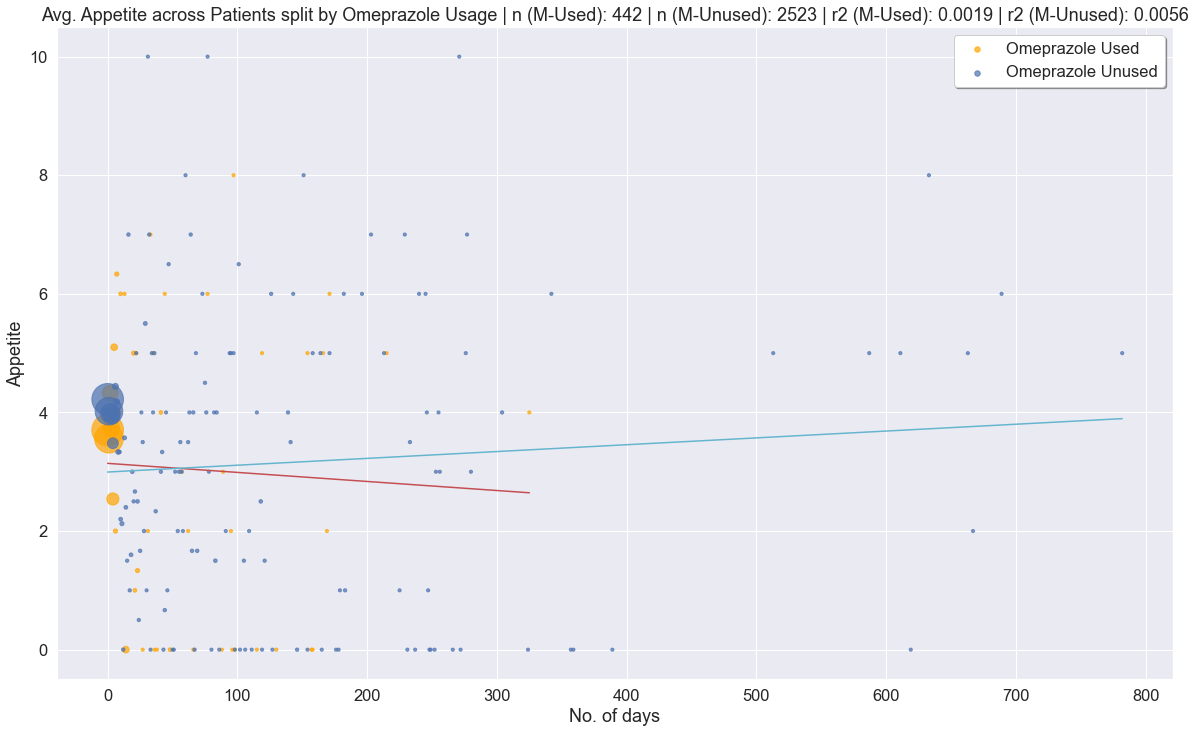

In [45]:
# get the appetite regplots split by omeprazole usage
fig, ax = plt.subplots()
x_ehr = df_c3['hos_days']
y_ehr = df_c3['appetite']['mean']
slope, intercept, r_value_ehr, p_value, std_err = stats.linregress(x_ehr,y_ehr)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_c3['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, slope*x_ehr + intercept, color='r')
x_amb = df_c4['hos_days']
y_amb = df_c4['appetite']['mean']
slope, intercept, r_value_amb, p_value, std_err = stats.linregress(x_amb,y_amb)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_c4['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, slope*x_amb + intercept, color='c')
lgnd = ax.legend((l1, l2), ('Omeprazole Used', 'Omeprazole Unused'), loc='best', shadow=True, facecolor='w')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax.set_xlabel('No. of days')
ax.set_ylabel('Appetite')
ax.set_title('Avg. Appetite across Patients split by Omeprazole Usage | n (M-Used): ' + str(m_num) + ' | n (M-Unused): ' + str(mn_num) + ' | r2 (M-Used): ' + "{:.4f}".format(r_value_ehr ** 2) + " | r2 (M-Unused): " + "{:.4f}".format(r_value_amb ** 2))
plt.savefig('./graphs/correlations/app_omepr_split.png', bbox_inches='tight')
plt.show()

In [46]:
# individual patient appetite trajectory
df_c1.IDEHR.value_counts().head(5)

3503    10
3006     9
3595     9
3672     9
3309     9
Name: IDEHR, dtype: int64

In [47]:
df_c1[df_c1['IDEHR'] == 3503]

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,appetite,hos_days,DrugName,DrugTime,drug_days
658,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:34:27.527,0.0,14,OMEPRAZOLE,2019-04-23 12:14:50.883,0
659,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:34:27.527,0.0,14,OMEPRAZOLE,2019-04-24 07:55:00.810,0
660,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:34:27.527,0.0,14,OMEPRAZOLE,2019-04-24 19:10:01.537,1
661,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:34:27.527,0.0,14,OMEPRAZOLE,2019-04-24 19:10:30.760,1
662,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:34:27.527,0.0,14,OMEPRAZOLE,2019-04-25 09:09:08.167,1
663,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:53:27.930,0.0,14,OMEPRAZOLE,2019-04-23 12:14:50.883,0
664,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:53:27.930,0.0,14,OMEPRAZOLE,2019-04-24 07:55:00.810,0
665,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:53:27.930,0.0,14,OMEPRAZOLE,2019-04-24 19:10:01.537,1
666,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:53:27.930,0.0,14,OMEPRAZOLE,2019-04-24 19:10:30.760,1
667,3503,2019-04-26 04:45:00,EHR,2019-04-09 10:58:55.067,16.0,Lung,1629,2019-04-23 11:53:27.930,0.0,14,OMEPRAZOLE,2019-04-25 09:09:08.167,1


C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


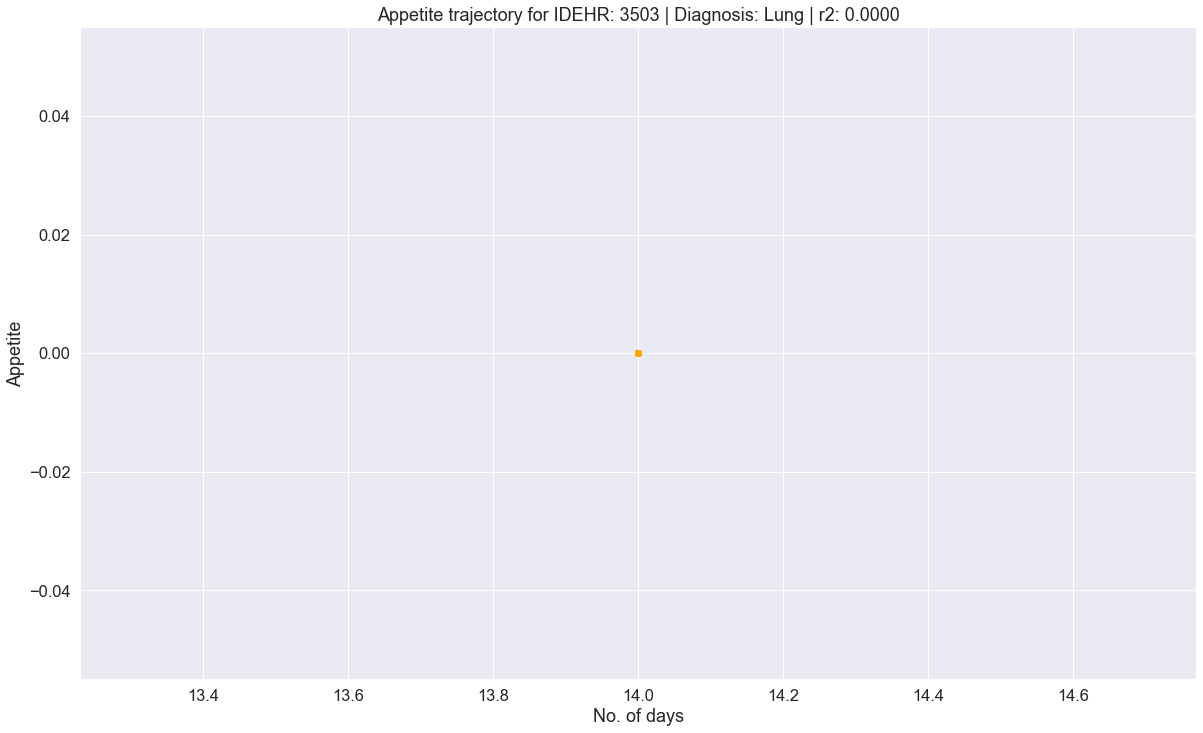

In [48]:
# get the appetite regplots split by omeprazole usage
pid = 3503
df_c3 = df_c1[df_c1['IDEHR'] == pid]
fig, ax = plt.subplots()
x = df_c3['hos_days']
y = df_c3['appetite']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
l1 = ax.scatter(x, y, color='orange')
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Appetite')
ax.set_title('Appetite trajectory for IDEHR: ' + str(pid) + ' | Diagnosis: ' + str(df_c3['Diagnosis'].unique()[0]) + ' | r2: ' + "{:.4f}".format(r_value ** 2))
plt.show()

C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


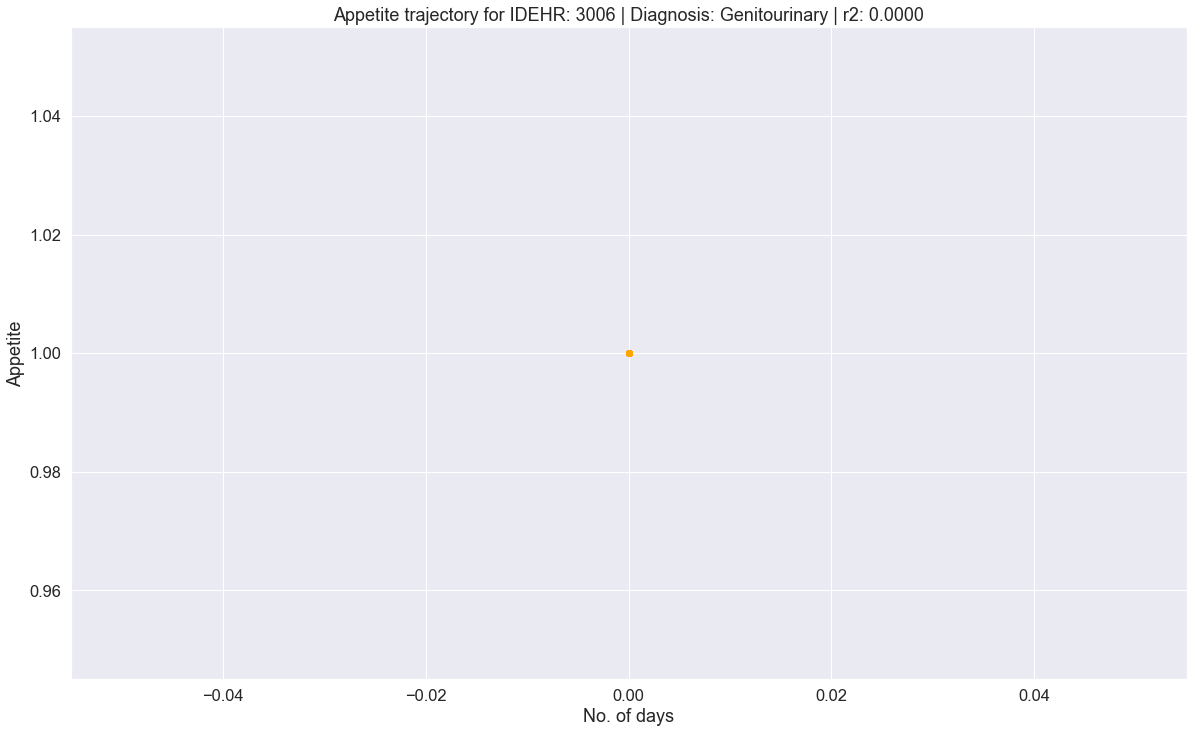

In [49]:
# get the appetite regplots split by omeprazole usage
pid = 3006
df_c3 = df_c1[df_c1['IDEHR'] == pid]
fig, ax = plt.subplots()
x = df_c3['hos_days']
y = df_c3['appetite']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
l1 = ax.scatter(x, y, color='orange')
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Appetite')
ax.set_title('Appetite trajectory for IDEHR: ' + str(pid) + ' | Diagnosis: ' + str(df_c3['Diagnosis'].unique()[0]) + ' | r2: ' + "{:.4f}".format(r_value ** 2))
plt.show()

C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\prate\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


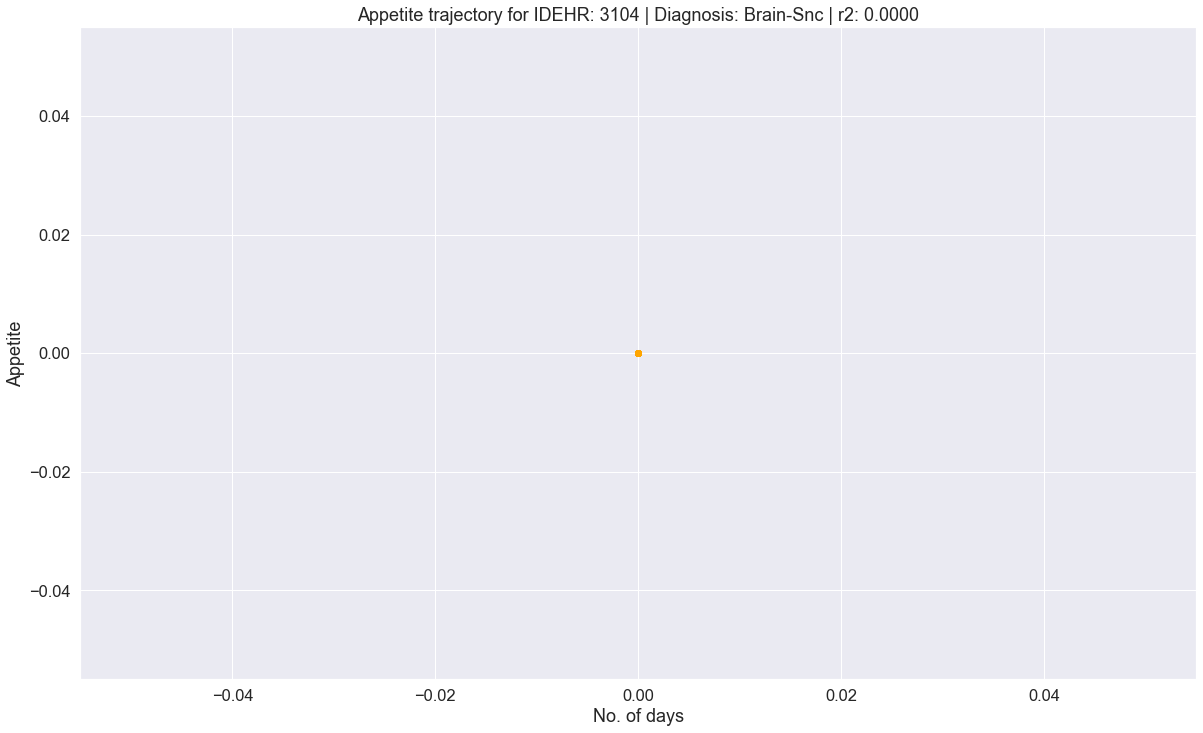

In [50]:
# get the appetite regplots split by omeprazole usage
pid = 3104
df_c3 = df_c1[df_c1['IDEHR'] == pid]
fig, ax = plt.subplots()
x = df_c3['hos_days']
y = df_c3['appetite']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
l1 = ax.scatter(x, y, color='orange')
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Appetite')
ax.set_title('Appetite trajectory for IDEHR: ' + str(pid) + ' | Diagnosis: ' + str(df_c3['Diagnosis'].unique()[0]) + ' | r2: ' + "{:.4f}".format(r_value ** 2))
plt.show()

## Nausea cor. Appetite ##

In [51]:
# get nausea dframe
df_referral = pd.read_csv('./vidas_data/survival_time.csv', parse_dates=['EOH', 'SOH'])
df_ns = pd.read_csv('./vidas_data/wH_DirectTable_VISITA_MED_VIDAS.csv', parse_dates=['TimeStamp_Insert'])
df_ns = df_ns[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'opt_nausea']].dropna().rename(columns={'opt_nausea': 'nausea'})
df_na = pd.merge(df_referral, df_ns, on=['IDEHR', 'EHRType']).dropna().sort_values(by=['IDEHR', 'TimeStamp_Insert'], ascending=[True, True]).reset_index(drop=True)
# clean up nausea dframe
df_na.loc[df_na['nausea'] == 'N.R.', 'nausea'] = np.nan
df_na['nausea'] = df_na.nausea.str.findall('(\w+)#')
df_na['nausea'] = df_na['nausea'].apply(lambda x: np.nan if isinstance(x, float) else x[0])
df_na.loc[df_na['nausea'] == 'occasionale', 'nausea'] = 'occasional'
df_na.loc[df_na['nausea'] == 'Controllata', 'nausea'] = 'controlled'
df_na.loc[df_na['nausea'] == 'persistente', 'nausea'] = 'persistent'
df_na['hos_days'] = pd.to_timedelta(df_na['TimeStamp_Insert'] - df_na['SOH']).dt.days
df_na.astype({'hos_days': 'float32'}).dtypes
df_na = df_na.dropna()
df_na.loc[df_na['nausea'] == 'persistent', 'nausea'] = 10.0
df_na.loc[df_na['nausea'] == 'controlled', 'nausea'] = 3.3
df_na.loc[df_na['nausea'] == 'occasional', 'nausea'] = 6.7
df_na['nausea'] = pd.to_numeric(df_na.nausea, errors='coerce')
df_na = df_na.rename(columns={'TimeStamp_Insert': 'Nausea_TimeStamp'})
# df_na = df_na[['IDEHR', 'Nausea_TimeStamp', 'nausea', 'hos_days']]
df_na

C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (16,17,18,19,20,21,22,50,97,98,100,116,142) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,Nausea_TimeStamp,nausea,hos_days
0,1421,2015-10-18 23:55:00,EHR,2015-10-08 13:17:15.407,10.0,Palliative (Non-Malignant),667,2015-10-09 13:14:08.350,3.3,0
1,1421,2015-10-18 23:55:00,EHR,2015-10-08 13:17:15.407,10.0,Palliative (Non-Malignant),667,2015-10-09 14:49:10.823,3.3,1
2,1421,2015-10-18 23:55:00,EHR,2015-10-08 13:17:15.407,10.0,Palliative (Non-Malignant),667,2015-10-12 12:35:54.400,3.3,3
3,1421,2015-10-18 23:55:00,EHR,2015-10-08 13:17:15.407,10.0,Palliative (Non-Malignant),667,2015-10-14 12:57:43.523,3.3,5
4,1421,2015-10-18 23:55:00,EHR,2015-10-08 13:17:15.407,10.0,Palliative (Non-Malignant),667,2015-10-15 12:24:44.353,3.3,6
...,...,...,...,...,...,...,...,...,...,...
8395,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-15 10:11:59.223,6.7,1
8396,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-17 15:40:20.710,6.7,4
8397,29308,2020-07-22 07:40:55,AMB,2020-07-13 13:16:36.820,8.0,Palliative (Cancer-Unspecified),1991,2020-07-21 09:34:00.360,6.7,7
8398,29411,2020-07-19 13:00:44,AMB,2020-07-17 13:54:50.597,1.0,Lung,1623,2020-07-17 18:59:35.257,6.7,0


In [52]:
# # concat with appetite dframe
# df_cor = pd.concat([df_aa, df_na])
# df_cor

In [53]:
df_c1 = df_aa[['IDEHR', 'appetite', 'hos_days']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()
df_c2 = df_na[['IDEHR', 'nausea', 'hos_days']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()

In [54]:
m_num = len(df_aa.IDEHR.unique())
n_num = len(df_na.IDEHR.unique())

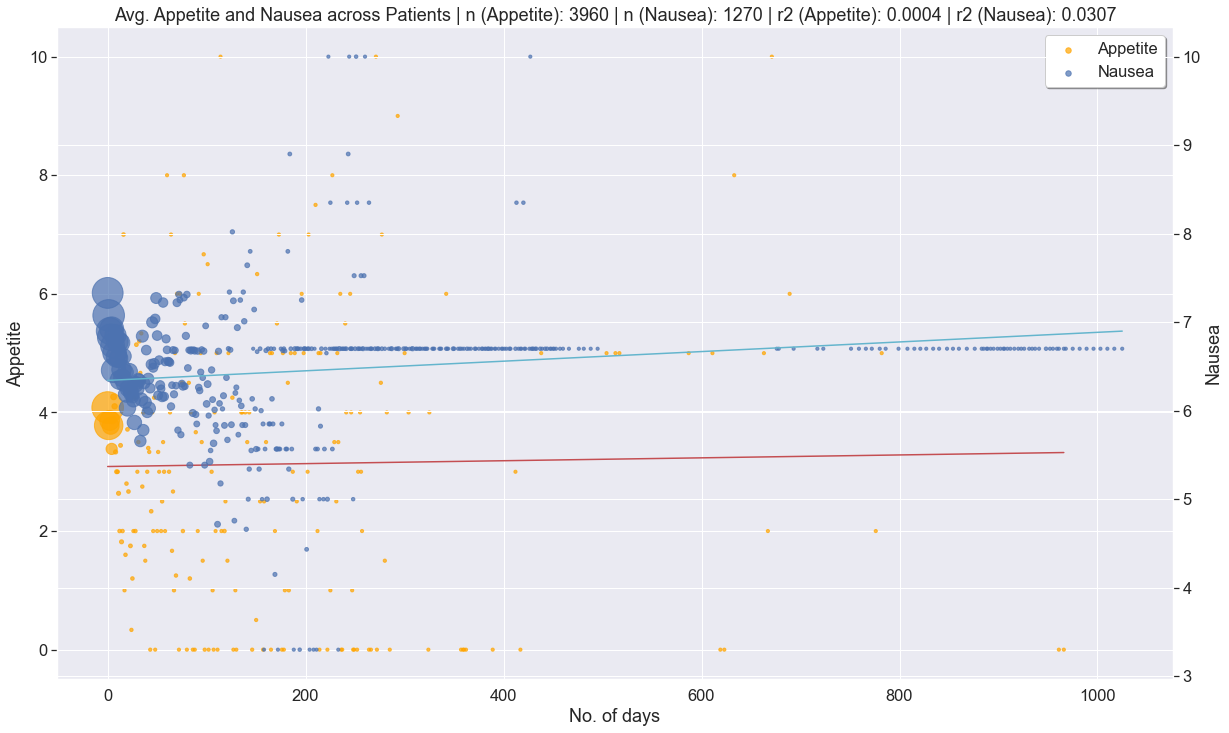

In [55]:
# get the appetite vs. nausea regplots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
x_1 = df_c1['hos_days']
y_1 = df_c1['appetite']['mean']
slope, intercept, r_value_1, p_value, std_err = stats.linregress(x_1,y_1)
l1 = ax1.scatter(x_1, y_1, color='orange', s=get_scatter_marker_size(df_c1['appetite']['count']), alpha=0.7)
ax1.plot(x_1, slope*x_1 + intercept, color='r')
x_2 = df_c2['hos_days']
y_2 = df_c2['nausea']['mean']
slope, intercept, r_value_2, p_value, std_err = stats.linregress(x_2,y_2)
l2 = ax2.scatter(x_2, y_2, color='b', s=get_scatter_marker_size(df_c2['nausea']['count']), alpha=0.7)
ax2.plot(x_2, slope*x_2 + intercept, color='c')
lgnd = ax1.legend((l1, l2), ('Appetite', 'Nausea'), loc='best', shadow=True, facecolor='w')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax1.set_xlabel('No. of days')
ax1.set_ylabel('Appetite')
ax2.set_ylabel('Nausea')
ax1.set_title('Avg. Appetite and Nausea across Patients | n (Appetite): ' + str(m_num) + ' | n (Nausea): ' + str(n_num) + ' | r2 (Appetite): ' + "{:.4f}".format(r_value_1 ** 2) + " | r2 (Nausea): " + "{:.4f}".format(r_value_2 ** 2))
plt.savefig('./graphs/correlations/app_nau_corr.png', bbox_inches='tight')
plt.show()